In [ ]:
import cv2 as cv
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow
from numpy import ndarray
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import os
from PIL import Image



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Images are pre-processed by function I wrote at the Lab1, which will help the images get the larger contrast between the target and background.

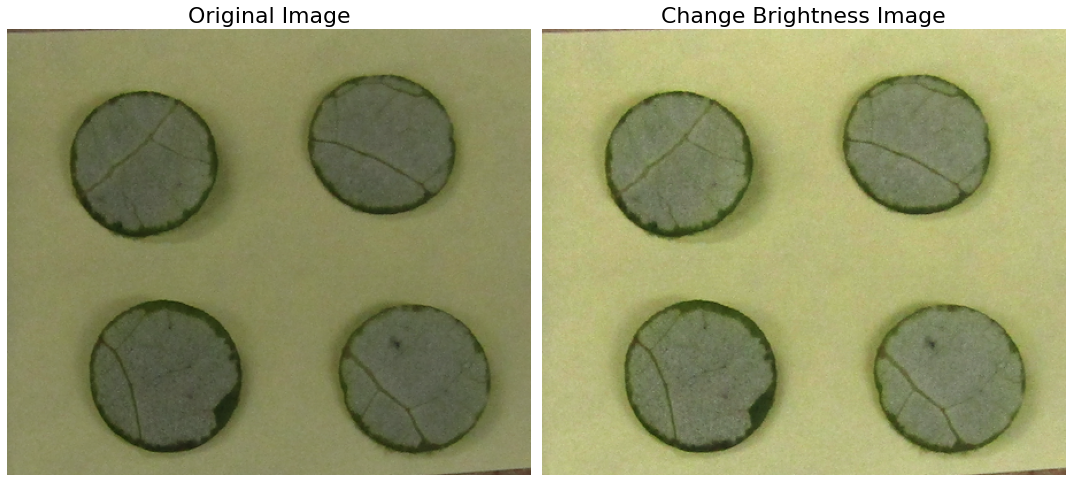

In [12]:
def brightness(image,num):
  img = imread(image)
  img_t = cv.cvtColor(img,cv.COLOR_BGR2HSV)
  h,s,v = cv.split(img_t)
  num = 1 + num
  #print(img_t)
  #Make the new images 15% brighter
  v1 = np.clip(cv.add(num*v,0),0,255)

  #trans mandatorily the arrry v1 type for mergeing the image
  v1 = v1.astype(np.uint8)
  #print(v1)

  img1 = np.uint8(cv.merge((h,s,v1)))
  img1 = cv.cvtColor(img1,cv.COLOR_HSV2BGR)
  
  fig, ax = plt.subplots(1,2, figsize=(15,7))
  ax[0].imshow(img)
  ax[0].set_title('Original Image', fontsize = 22)
  ax[0].set_axis_off()

  ax[1].imshow(img1);
  ax[1].set_title('Change Brightness Image', fontsize = 22)
  ax[1].set_axis_off()
  fig.tight_layout()

  #I do real spend too much time to deal why the method find_skin could not deal the picture after changing brightness
  #Finally, I found that when I use the hsv to deal it, it lost the transparency, so I need to fix it.
  plt.savefig("tem.png")
  img = Image.open("/content/tem.png")
  img = img.convert('RGBA')
  img_blender = Image.new('RGBA', img.size, (0,0,0,0))
  img = Image.blend(img_blender, img, 1)
  img.save("tem1.png")
  img = imread('/content/tem1.png')
  
  return img

img_brighter = brightness("/content/drive/MyDrive/images/Lab2-image/1.png",0.35)

#Main

I hope to use the thresholding technique to find the leaves, because there are obviously difference between the leaves and background.

Firstly, We should read and trans it to the grayscale image. Then We should get and display the histogram, which could help us determine a good threshold to separate foreground from background.

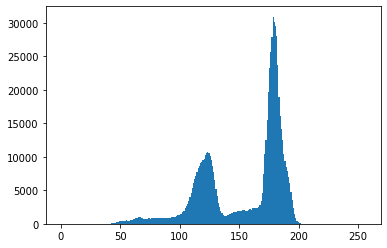

In [30]:
img1 = cv.imread("/content/drive/MyDrive/images/Lab2-image/1.png", 0)

plt.hist(img1.ravel(), 256, [0, 256])
plt.show()

According to the histogram, we could easily determin the threshold = 100, that is the obvious. Then, output the binary image and the original one.

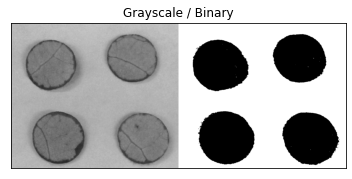

In [31]:
threshold = 140

ret, img1_binary = cv.threshold(img1, threshold, 255, cv.THRESH_BINARY)

plt.imshow(np.hstack((img1, img1_binary)), 'gray', vmin=0, vmax=255)
plt.title("Grayscale / Binary")
plt.xticks([]),plt.yticks([])
plt.show()

Our threshold estimate did not result in the desired output so we equalize the histogram to see if this approach yields better results.

We go for the Contrast Limited Adaptive Histogram Equalization (CLAHE) method since our background is not uniform.

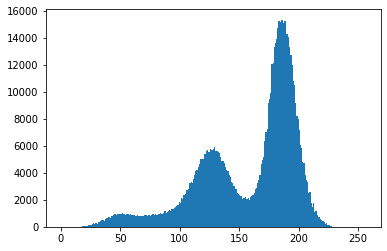

In [32]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img1_equ = clahe.apply(img1)

plt.hist(img1_equ.ravel(), 256, [0, 256])
plt.show()

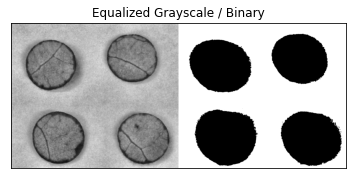

In [33]:
threshold_equ = 160
ret, img1_equ_binary = cv.threshold(img1, threshold_equ, 255, cv.THRESH_BINARY)

plt.imshow(np.hstack((img1_equ, img1_equ_binary)), 'gray', vmin=0, vmax=255)
plt.title("Equalized Grayscale / Binary")
plt.xticks([]),plt.yticks([])
plt.show()

As we can see, after using the equalized image, we got better results.

Next, we should calculate the area of these leaves.

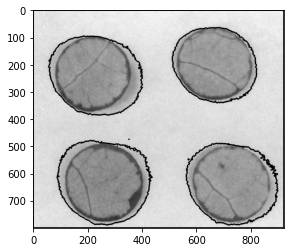

In [34]:
contours, hierarchy = cv.findContours(img1_equ_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

img1_contour = cv.drawContours(img1, contours, -1, (0, 255, 0), 3)

plt.imshow(img1_contour, cmap="gray")

In [37]:
from numpy.ma.core import arange
rows, cols = img1.shape
img1_contour_clean = np.zeros((rows, cols), np.uint8)

contours = [cnt for cnt in contours if cv.contourArea(cnt)>500]
area = 0
for x in range(0,len(contours)):  
    area = area + cv.contourArea(contours[x])
    print(cv.contourArea(contours[x]))
print(len(contours))
print(area)
print(img1.size)
print(area/img1.size)


77822.5
82738.0
78008.0
66643.5
4
305212.0
737600
0.41379067245119305


Now, let's try this method in a different picture.

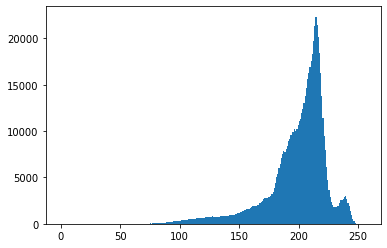

In [21]:
img1 = cv.imread("/content/drive/MyDrive/images/Lab2-image/2.png", 0)

plt.hist(img1.ravel(), 256, [0, 256])
plt.show()

As we can see, I could not find the obviously difference between the target and the background. So, if it doesn't have the obviously difference between the target and the background, we could not use this method.